## Solving quadratic unconstrained binary optimization (QUBO) problems with Adaptive Derivative Assembled Problem Tailored - Quantum Approximate Optimization Algorithm (ADAPT-QAOA)

<img src="img/adaptqaoa.png" width="50%" />

Picture copied from Liao, Y., Hsieh, M., & Ferrie, C. (2024). Quantum optimization for training quantum neural networks. Quantum Machine Intelligence, 6(1). https://doi.org/10.1007/s42484-024-00169-w

ADAPT-QAOA mixer implementation follows this code https://github.com/frozenwolf64/Adapt-QAOA/

The QAOA circuit consists of a cost Hamiltonian and a mixer Hamiltonian. 

The cost Hamiltonian defines our problem and the mixer Hamiltonian can be thought as a function that allows us to explore different solutions to the problem. 

The variational parameters for the cost and mixer Hamiltonians are optimized using a classical computer. 

In this code, we convert the QUBO matrix to an Ising Hamiltonian.

In [55]:
from qiskit import QuantumCircuit, transpile

from qiskit.visualization import plot_distribution
from qiskit.circuit import ParameterVector

from qiskit_aer import AerSimulator

from scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt

from qiskit.quantum_info import SparsePauliOp, commutator

from qiskit.primitives import StatevectorEstimator

from qiskit.circuit.library import PauliEvolutionGate

from gurobi_optimods.qubo import solve_qubo

In [56]:
# Define the backend used
backend = AerSimulator(method='statevector')
estimator = StatevectorEstimator()

We want to convert the QUBO matrix to an Ising Hamiltonian and use the Ising Hamiltonian as a cost Hamiltonian. This is done by making a transformation to the QUBO matrix elements,
$$x_i \rightarrow \frac{1-z_i}{2}.$$

With the following function, we get the operators that we can apply to the quantum circuit.

In [57]:
def convert_qubo_to_ising(qubo):
    # Number of qubits
    n = len(qubo)

    # Calculate the offset also, this is not important for the optimization
    offset = 0
    
    operator_list = []

    for i in range(n):
        for j in range(i, n):
            # Initialize the Pauli operator with all I's
            pauli_operator = list("I"*n)
            
            if i == j:
                pauli_operator[i] = "Z"
                ising_value = -(1/2)*np.sum(qubo[i])
            else:
                pauli_operator[i] = "Z"
                pauli_operator[j] = "Z"
                ising_value = (1/2)*qubo[i][j]

            if not ising_value == 0:
                ising_pauli_op = (''.join(pauli_operator), ising_value)
                operator_list.append(ising_pauli_op)

            offset += (1/2)*qubo[i][j]

    operators = SparsePauliOp.from_list(operator_list)

    return operators

In [58]:
# Define the QUBO problem. Here we can change the variables "features", "samples," "alpha" and "seed".
# (Given by OP bank)
def generate_problem(features, samples, alpha, seed):
    rng = np.random.default_rng(seed=seed)
    n_features = features
    n_samples = samples

    #X = np.ones(n_features) # Feature encoding binary vector 
    V = rng.integers(0,2, size=(n_samples,1)) # Example model target outputs 
    U = rng.random(size=(n_samples,n_features)) # Example model variables (1 feature per column --> (sample x feature) dimensional matrix)

    p_Vj = np.corrcoef(U, V, rowvar=False)[1:,:1] # Correlation with model target outputs
    p_ij = np.corrcoef(U,rowvar=False)            # Correlation between the features

    p_Vj = np.abs(p_Vj)
    p_ij = np.abs(p_ij)

    np.fill_diagonal(p_ij,0)

    s= n_features
    n, m = np.shape(p_Vj)
    matrix_pVj = np.zeros((s,s))
    for i in range(s):
        matrix_pVj[i,i] = p_Vj[i]
    
    # Weighing the independence vs prediction power of variables
    alpha = alpha

    Q = (alpha * p_ij) - (1-alpha)*matrix_pVj

    return Q

Define the ADAPT-QAOA mixer pool

In [59]:
def mixer_pool_single(qubits):
    pool = []
    qaoa_x = []
    qaoa_y = []
    
    for i in range(qubits):
        op = ''
        for j in range(qubits):
            if i!=j:
                op = op + "I"
            else:
                op = op + 'X'
        pool.append([op])
        qaoa_x.append(op)
    pool.append(qaoa_x)
    
    for i in range(qubits):
        op = ''
        for j in range(qubits):
            if i!=j:
                op = op + "I"
            else:
                op = op + 'Y'
        pool.append([op])
        qaoa_y.append(op)
    pool.append(qaoa_y)
        
    pool_ops = []
    
    for ops in pool:
        pool_ops2 = []
        if len(ops) == 1:
            op = ((''.join(ops[0]),1))
            pool_ops.append(SparsePauliOp.from_list([op]))
        else:
            pool_ops2.append((''.join(ops[0]),1))
            for i in range(1,len(ops)):
                pool_ops2.append((''.join(ops[i]),1))
            pool_ops.append(SparsePauliOp.from_list(pool_ops2))
            
    return pool_ops

In [60]:
def mixer_pool_multi(qubits):
    paulis = ["X","Y","Z"]
    
    pool = []
    for i in range(qubits-1):
        for j in range(i+1,qubits):
            for pauli_op1 in paulis:
                for pauli_op2 in paulis:
                    op = 'I'*i + pauli_op1 + 'I'*(j-i-1) +pauli_op2 + 'I'*(qubits-j-1)
                    pool.append(op)
    
    pool_op = []
    for op in pool:
        multiop = (''.join(op),1)
        pool_op.append(SparsePauliOp.from_list([multiop]))
                    
    return pool_op

In [61]:
def mixer_pool(qubits):
    mixersingle = mixer_pool_single(qubits)
    mixermulti = mixer_pool_multi(qubits)

    mixer = mixersingle.copy()

    for op in mixermulti:
        mixer.append(op)
    
    return mixer

In [62]:
def apply_cost_layer(qc, n, qubo, gamma): 
    cost_layer = PauliEvolutionGate(qubo, gamma)
    qc.append(cost_layer, range(n))
    
    qc.barrier()

In [63]:
def apply_mixer_layer(qc, max_mixer, beta, qubits):
    evomixer = PauliEvolutionGate(max_mixer, beta)
    qc.append(evomixer, range(qubits))

    qc.barrier()

In [64]:
#Function to initialize parameters for a QAOA layer
def initialize_parameters(theta):
    theta = list(theta)
    
    initial_gamma = 2 * np.pi
    initial_beta = np.pi
        
    theta.append(initial_gamma)
    theta.append(initial_beta)
    
    return theta

In [65]:
# Calculate the expectation value using the QUBO matrix. We are trying to minimize this expectation value.
def calculate_expectation_value(theta, qc, qubo, parameters, exp_value_list, shots=10000):
    # Assign the gammas and the betas to the circuit
    qc_assigned_parameters = qc.assign_parameters({parameters:theta})
    # Transpile the circuit for the backend and measure the qubits
    qc_assigned_parameters.measure_all()
    qc_transpiled = transpile(qc_assigned_parameters, backend)

    # Run the circuit on the backend
    result = backend.run(qc_transpiled, shots=shots).result()

    # Save the counts to a variable
    counts = result.get_counts()

    exp_value = 0

    for bitstring in counts.keys():
        # Calculate the occurrence of a bitstring with respect to the number of shots
        occurrence_bitstring = counts[bitstring] / shots

        # Calculate the QUBO result of a bitstring
        qubo_value = 0
        for i in range(len(qubo)):
            for j in range(len(qubo)):
                if i == j:
                    qubo_value += qubo[i][j]*int(bitstring[i])
                else:
                    qubo_value += qubo[i][j]*int(bitstring[i])*int(bitstring[j])

        # Expectation values of all bitstrings are summed
        exp_value += occurrence_bitstring * qubo_value
    
    exp_value_list.append(exp_value)
    
    return exp_value


In [66]:
def optimize_parameters(qc, qubo, parameters, theta):
    # Save the expectation values the optimization gives us so that we can visualize the optimization
    exp_value_list = []

    # Here we can change the classical optimization method etc.
    min_minimized_optimization = minimize(calculate_expectation_value, theta, method="Powell", args=(qc, qubo, parameters, exp_value_list))

    # Save the objective value the optimization finally gives us
    minimum_objective_value = min_minimized_optimization.fun
    min_exp_value_list = exp_value_list

    return min_minimized_optimization.x, minimum_objective_value, min_exp_value_list

In [67]:
def adapt_qaoa(Q):
    # Classical solver
    result = solve_qubo(Q).objective_value
    
    n = len(Q[0])

    qc = QuantumCircuit(n)
    qc.h(range(n))

    qc.barrier()

    p = 0 
    theta = []
    parameters = ParameterVector("theta", 2)
    
    ising = convert_qubo_to_ising(Q)

    gamma_0 = 0.01
    applied_mixers = []

    mixers = mixer_pool(n)

    while True: 
        gradients = []

        if len(theta)<2:
            qc_gradient = qc.copy()
        else:    
            qc_gradient = qc.assign_parameters({parameters: theta})

        apply_cost_layer(qc_gradient, n, ising, gamma_0)

        comm = (-1j) * commutator(ising, mixers[0])
        job = estimator.run([(qc_gradient, comm)])

        pub_result = job.result()[0]

        gradients.append(pub_result.data.evs)

        exp = pub_result.data.evs
        max_mixer = mixers[0]

        for i in range(len(mixers)-1):
            comm = (-1j) * commutator(ising, mixers[i+1])
            #commop = SparsePauliOp.from_operator(comm)
            job = estimator.run([(qc_gradient, comm)])
 
            # Get results for the first (and only) PUB
            pub_result = job.result()[0]

            gradients.append(pub_result.data.evs)
            if pub_result.data.evs > exp:
                exp = pub_result.data.evs
                max_mixer = mixers[i+1]
        
        print(f"Layer {p}, mixer applied: {max_mixer}")
        
        scaled_gradient_norm = np.linalg.norm(gradients)/len(mixers)

        if p >= 1:
            print(f"Approximation ratio: {optimized_minimum/result}")
            if optimized_minimum/result >= 0.878:
                return optimized_minimum, qc, parameters, theta, exp_value_list
        
        # Increase layer number
        p += 1
        parameters.resize(2*p)

        theta = initialize_parameters(theta)
        
        # Save the applied mixers
        applied_mixers.append(max_mixer)

        apply_cost_layer(qc, n, ising, parameters[-2])
        apply_mixer_layer(qc, max_mixer, parameters[-1], n)
        
        ## Optimize for the new layer
        theta, optimized_minimum, exp_value_list = optimize_parameters(qc, Q, parameters, theta)

In [68]:
# Run the ADAPT-QAOA
Q = generate_problem(5, 5, 0.2, 51)
optimized_minimum, qc, parameters, theta, exp_value_list = adapt_qaoa(Q)

New QUBO solution found with objective 0.0
New QUBO solution found with objective -0.6815816669124609


C:\Users\tpihkako19\AppData\Local\Temp\ipykernel_4852\2962490866.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  matrix_pVj[i,i] = p_Vj[i]


Layer 0, used mixer: SparsePauliOp(['YIIII', 'IYIII', 'IIYII', 'IIIYI', 'IIIIY'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])
Layer 1, used mixer: SparsePauliOp(['XIIII', 'IXIII', 'IIXII', 'IIIXI', 'IIIIX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])
Approximation ratio: 0.47983233034672673
Layer 2, used mixer: SparsePauliOp(['YXIII'],
              coeffs=[1.+0.j])
Approximation ratio: 0.5968215547289247
Layer 3, used mixer: SparsePauliOp(['ZYIII'],
              coeffs=[1.+0.j])
Approximation ratio: 0.6508563538057796
Layer 4, used mixer: SparsePauliOp(['YZIII'],
              coeffs=[1.+0.j])
Approximation ratio: 0.9980874355209756


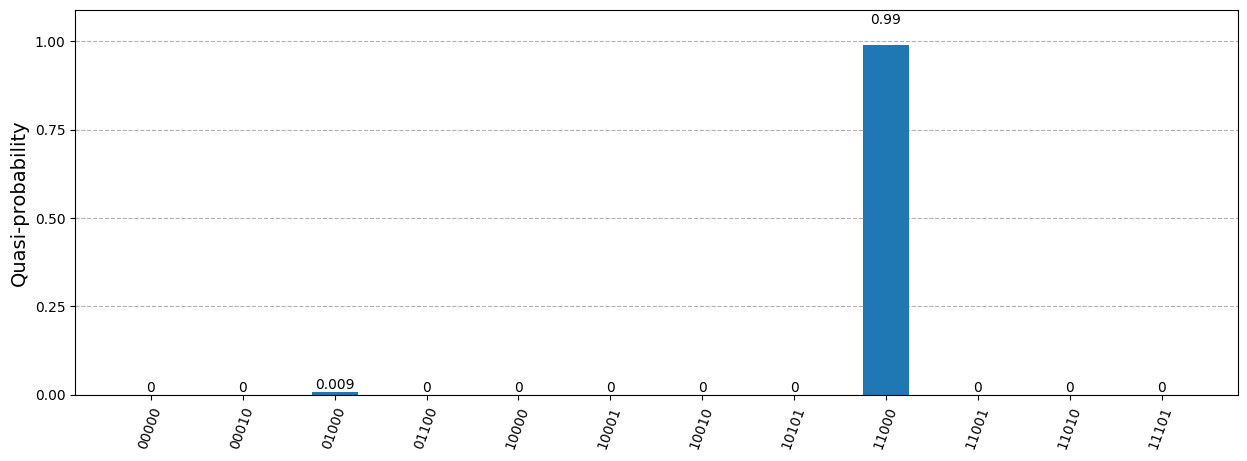

In [69]:
qc_assigned_parameters = qc.assign_parameters({parameters:theta})
qc_transpiled = transpile(qc_assigned_parameters, backend=backend)
qc_transpiled.measure_all()

counts = backend.run(qc_transpiled, shots=50000).result().get_counts()

plot_distribution(counts, figsize=(15, 5))

In [70]:
highest_possible_solution = 0
max_count = 0
second_highest = 0
second_key = 0
for key, count in counts.items():
    if count > max_count:
        second_key = highest_possible_solution
        second_highest = max_count
        max_count = count
        highest_possible_solution = key
print(f'Highest possible solution: {highest_possible_solution}')

# Convert string to array
X = np.fromstring(highest_possible_solution, np.int8) - 48

# Calculate the result using the highest possible solution
E = X.T @ Q @ X

print(f'Result: {E}')
print(max_count)
print(second_highest)
print(second_key)

Highest possible solution: 11000
Result: -0.681581666912461
49486
15
10000


C:\Users\tpihkako19\AppData\Local\Temp\ipykernel_4852\1787368524.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  X = np.fromstring(highest_possible_solution, np.int8) - 48


In [71]:
result = solve_qubo(Q)

New QUBO solution found with objective 0.0
New QUBO solution found with objective -0.6815816669124609


Plot the optimizer performance

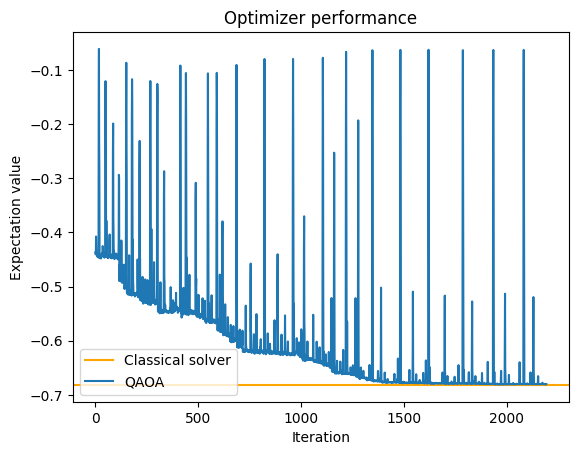

In [72]:
plt.title('Optimizer performance')
plt.xlabel('Iteration')
plt.ylabel('Expectation value')
plt.axhline(y=result.objective_value, color='orange', label='Classical solver')
plt.plot(exp_value_list, label='ADAPT-QAOA')
plt.legend()
plt.show()

In [73]:
print(f'Minimum objective value: {optimized_minimum}')

Minimum objective value: -0.6802780980267699
